In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import skimage.color
import skimage.io

from config import Config
import utils
import model as modellib
import visualize
from model import log

C:\Users\tianh\Desktop\environments\mlenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [3]:
class ToyConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "toy"
    
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 1e-6
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ToyConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  1e-05
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           toy
NUM_CLASSES                    6
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POS

In [18]:
class ToyDataset(utils.Dataset):
    def prepare(self, root):
        self.class_names = ['BG']
        image_idx = 0
        for class_name in os.listdir(root):
            class_idx = len(self.class_names)
            self.class_names.append(class_name)
            self.add_class('local_dataset', class_idx, class_name)
            class_root = os.path.join(root, class_name)
            image_root = os.path.join(class_root, 'images')
            for image_filename in os.listdir(image_root):
                image_path = os.path.join(class_root, 'images', image_filename)
                mask_path = os.path.join(class_root, 'masks', image_filename)
                self._image_ids.append(image_idx)
                self.add_image('local_dataset', image_idx, image_path, class_name=class_name, class_idx=class_idx, mask_path=mask_path)
                image_idx += 1
            self.num_classes = len(self.class_names)
            self.source_class_ids = {'local_dataset': 0}
                
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        mask_path = info['mask_path']
        mask_path = mask_path.replace('image', 'mask')
        class_name = info['class_name']
        class_idx = info['class_idx']
        mask_raw = skimage.io.imread(mask_path)
        mask = np.zeros_like(mask_raw)
        mask[(mask_raw > 10)] = 1
        num_class = len(self.class_names)
        mask_output = np.zeros((mask.shape[0], mask.shape[1], 1))
        mask_output[:,:,0] = mask
        class_ids = np.array([class_idx])
        mask_output = mask_output.astype(int)
        class_ids = class_ids.astype(int)
        return mask_output, class_ids

In [19]:
toy_dataset_train = ToyDataset()
toy_dataset_val = ToyDataset()

In [20]:
toy_dataset_train.prepare('toy_dataset/train')
toy_dataset_val.prepare('toy_dataset/val')

[ 22 125  42] (376, 672, 3)


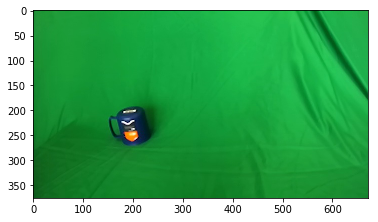

[0] [1] (376, 672, 1) (376, 672)


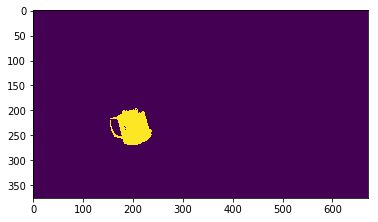

In [21]:
sample_idx = 100
plt.figure()
image_sample = toy_dataset_train.load_image(sample_idx)
print(image_sample[0,0], image_sample.shape)
plt.imshow(image_sample)
plt.show()
plt.figure()
mask_sample_raw, class_ids = toy_dataset_train.load_mask(sample_idx)
mask_sample = np.mean(mask_sample_raw, axis=2)
print(mask_sample_raw[0,0], class_ids, mask_sample_raw.shape, mask_sample.shape)
plt.imshow(mask_sample)
plt.show()

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [ ]:
init_with = "coco"
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
model.train(toy_dataset_train, toy_dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
model.train(toy_dataset_train, toy_dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
class InferenceConfig(ToyConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()[1]

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# Test on a random image
image_id = random.choice(toy_dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(toy_dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            toy_dataset_train.class_dict, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            toy_dataset_val.class_dict, r['scores'], ax=get_ax())

In [ ]:
sample_image = skimage.io.imread('toy_samples/sample1.jpg')

sample_results = model.detect([sample_image], verbose=1)

sample_r = sample_results[0]
visualize.display_instances(sample_image, sample_r['rois'], sample_r['masks'], sample_r['class_ids'], 
                            toy_dataset_val.class_dict, sample_r['scores'], ax=get_ax())